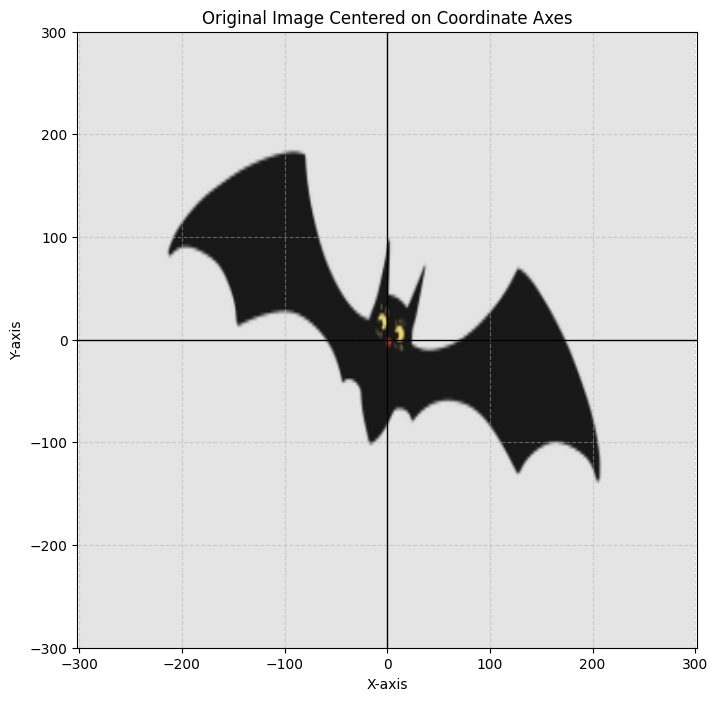

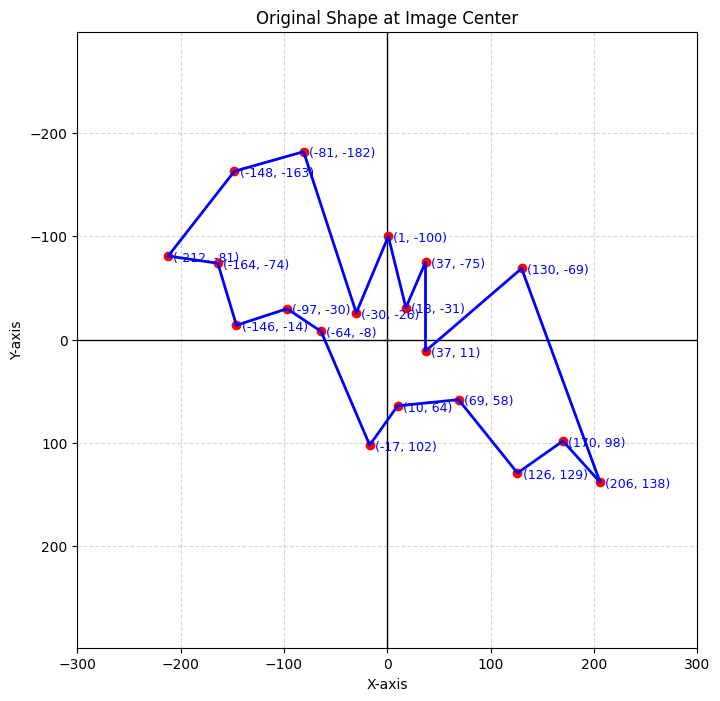

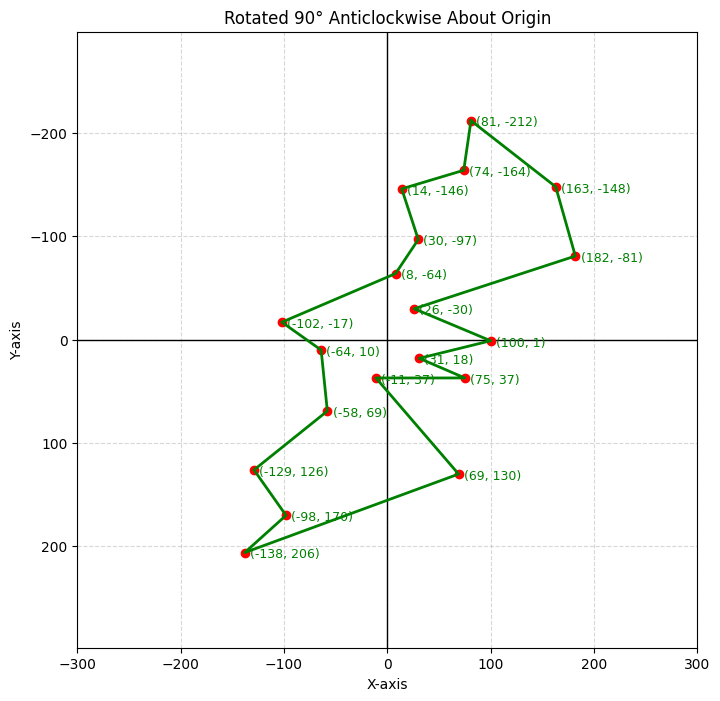

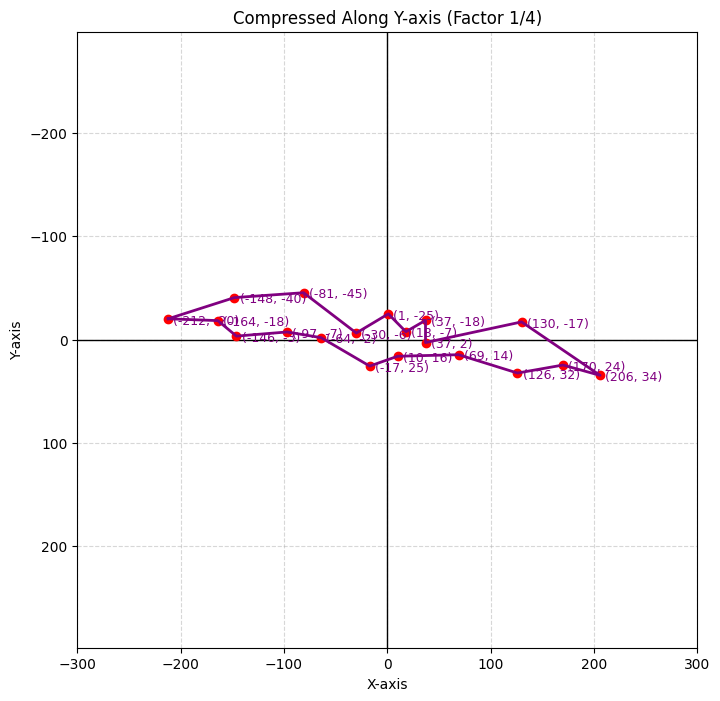

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_plot_vertices(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not load image")
        return None, None, None

    img = cv2.resize(img, (600, 600))
    h, w = img.shape[:2]
    center = np.array([w // 2, h // 2])

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found")
        return None, None, None

    largest = max(contours, key=cv2.contourArea)
    epsilon = 0.01 * cv2.arcLength(largest, True)
    approx = cv2.approxPolyDP(largest, epsilon, True)
    vertices = approx.reshape(-1, 2)

    centered_vertices = vertices - center

    return centered_vertices, img, center

def rotate_anticlockwise_90(vertices):
    R = np.array([[0, -1],
                  [1,  0]])
    return vertices @ R.T

def compress_y_axis(vertices, factor=1/4):
    C = np.array([[1, 0],
                  [0, factor]])
    return vertices @ C.T

def plot_original_image_matplotlib(image, center, title="Original Image Centered on Axes"):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Flip image vertically to correct OpenCV vs Cartesian Y-axis difference
    img_rgb_flipped = np.flipud(img_rgb)

    extent = [-center[0], center[0], -center[1], center[1]]

    plt.figure(figsize=(8, 8))
    # Use origin='lower' because we flipped the image manually
    plt.imshow(img_rgb_flipped, extent=extent, origin='lower')
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.axis('equal')
    plt.xlim(-center[0], center[0])
    plt.ylim(-center[1], center[1])
    plt.show()


def plot_in_quadrants(vertices, center, title, color='blue'):
    plt.figure(figsize=(8, 8))
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.5)

    for (x, y) in vertices:
        plt.plot(x, y, 'ro')
        plt.text(x + 5, y + 5, f'({int(x)}, {int(y)})', fontsize=9, color=color)

    connected = np.vstack([vertices, vertices[0]])
    plt.plot(connected[:, 0], connected[:, 1], color=color, linewidth=2)

    plt.title(title)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.axis('equal')
    plt.xlim(-center[0], center[0])
    plt.ylim(-center[1], center[1])
    plt.gca().invert_yaxis()
    plt.show()

image_path = '/content/bat.png'
vertices, image, center = detect_and_plot_vertices(image_path)

if vertices is not None:
    plot_original_image_matplotlib(image, center, "Original Image Centered on Coordinate Axes")

    plot_in_quadrants(vertices, center, "Original Shape at Image Center", color='blue')

    rotated = rotate_anticlockwise_90(vertices)
    plot_in_quadrants(rotated, center, "Rotated 90° Anticlockwise About Origin", color='green')

    compressed = compress_y_axis(vertices)
    plot_in_quadrants(compressed, center, "Compressed Along Y-axis (Factor 1/4)", color='purple')
